In [1]:
import pandas as pd
import numpy as np
import statsmodels
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [54]:
dfhb = pd.read_csv('Heritability.csv',index_col=0)
dfhb.head()

geneID        Hb  logGEMean
GRMZM5G807592  GRMZM5G807592  0.213518   1.056433
GRMZM5G862955  GRMZM5G862955  0.405107   1.500177
GRMZM5G876913  GRMZM5G876913  0.677785   1.527247
GRMZM5G881135  GRMZM5G881135  0.728287   1.813778
GRMZM5G892769  GRMZM5G892769  0.427307   0.774220

In [55]:
dfhb = dfhb.loc[dfhb['Hb']!=0]

In [5]:
abgo = open('ATH_GO_GOSLIM.txt','r')
cDict={'P':'Biological process','C':'Cellular component','F':'Molecular function'}
abgoDict = {}
abgoList=[]
for aline in abgo:
    if aline.startswith('!'):continue
    GO = aline.strip().split('\t')[5]
    Desc = aline.strip().split('\t')[4]
    Category = cDict[aline.strip().split('\t')[7]]
    if not GO in abgoDict:
        abgoDict[GO]={}
        abgoDict[GO]['Desc']= Desc
        abgoDict[GO]['Category'] = Category
    else:continue

In [6]:
goDict={}
dfgo = open('All_ass.txt','r')
for aline in dfgo:
    x = aline.strip().split('\t')
    geneID = x[0]
    goList = x[1].split(';')
    for ago in goList:
        if not ago in abgoDict:continue
        elif not ago in goDict: goDict[ago]=[geneID]
        else: goDict[ago].append(geneID)

In [7]:
gList=[]
pList = []
GOHbDict={}
for ago in goDict:
    geneList = goDict[ago]
    geneIn = [x for x in geneList if x in dfhb.index]
    if len(geneIn)< 25:continue
    elif len(geneIn)>500:continue
    else:
        GOHbDict[ago]={}
        hbGene = dfhb.loc[geneIn]['Hb'].values
        hbPop = dfhb.drop(labels=geneIn)['Hb'].values
        hbGeneDist = np.log(hbGene)
        hbPopDist = np.log(hbPop)
        
        #fc = np.log2(np.mean(hbGene)/np.mean(hbPop))
        fc = np.log2(np.median(hbGene)/np.median(hbPop))
        p = stats.kstest(hbGeneDist, hbPopDist)[1]
        GOHbDict[ago]['desc'] = abgoDict[ago]['Desc']
        GOHbDict[ago]['Category'] = abgoDict[ago]['Category']
        GOHbDict[ago]['pValue'] = p
        GOHbDict[ago]['log2FoldChange'] = fc
        GOHbDict[ago]['AssignedGeneNumber'] = len(geneIn)


"""
    if np.mean(hbGene) > np.mean(hbPop):
        p = stats.kstest(hbGene, hbPop, alternative='greater')[1]
        if p<=0.05: gList.append('higher')
        else: gList.append('NS')
    else: 
        p= stats.kstest(hbGene, hbPop, alternative='less')[1]
        if p<=0.05: gList.append('lower')
        else:gList.append('NS')
    pList.append(p)


"""        

NameError: name 'dfhb' is not defined

In [59]:
dfGO = pd.DataFrame.from_dict(GOHbDict,orient='index')
dfGO

desc            Category  \
GO:0046914             transition metal ion binding  Molecular function   
GO:0009058                     biosynthetic process  Biological process   
GO:0009308                  amine metabolic process  Biological process   
GO:0009407                  toxin catabolic process  Biological process   
GO:0009743                 response to carbohydrate  Biological process   
...                                             ...                 ...   
GO:0048589                     developmental growth  Biological process   
GO:0034599    cellular response to oxidative stress  Biological process   
GO:0000082    G1/S transition of mitotic cell cycle  Biological process   
GO:0005778                     peroxisomal membrane  Cellular component   
GO:0042147  retrograde transport, endosome to Golgi  Biological process   

                  pValue  log2FoldChange  AssignedGeneNumber  
GO:0046914  4.617913e-01        0.050971                  68  
GO:0009058  5.638298e-02        0.059555                 459  
GO:0009308  1.503319e-01        0.137383                 101  
GO:0009407  3.876930e-02        0.122929                 247  
GO:0009743  3.169576e-09       -0.262909                 437  
...                  ...             ...                 ...  
GO:0048589  3.355686e-02       -0.430324                  45  
GO:0034599  2.319134e-01        0.250896                  45  
GO:0000082  6.365891e-01       -0.177504                  25  
GO:0005778  1.413337e-01        0.403969                  25  
GO:0042147  1.095241e-01       -0.234594                  32  

[984 rows x 5 columns]

Text(0, 0.5, 'Number of GO terms')

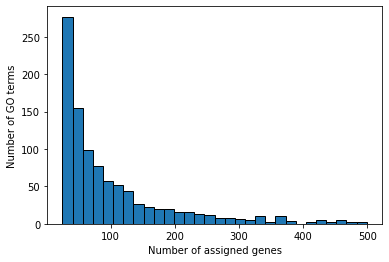

In [60]:
plt.hist(dfGO.AssignedGeneNumber,bins=30, edgecolor='black')
plt.xlabel('Number of assigned genes')
plt.ylabel('Number of GO terms')

In [61]:
import statsmodels.api as sm
from statsmodels.stats._knockoff import RegressionFDR
fdr = statsmodels.stats.multitest.multipletests(dfGO['pValue'].values, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)
dfGO['FDR'] = fdr[1]
dfGO.to_csv('Hb_GO.csv')
dfGO

desc            Category  \
GO:0046914             transition metal ion binding  Molecular function   
GO:0009058                     biosynthetic process  Biological process   
GO:0009308                  amine metabolic process  Biological process   
GO:0009407                  toxin catabolic process  Biological process   
GO:0009743                 response to carbohydrate  Biological process   
...                                             ...                 ...   
GO:0048589                     developmental growth  Biological process   
GO:0034599    cellular response to oxidative stress  Biological process   
GO:0000082    G1/S transition of mitotic cell cycle  Biological process   
GO:0005778                     peroxisomal membrane  Cellular component   
GO:0042147  retrograde transport, endosome to Golgi  Biological process   

                  pValue  log2FoldChange  AssignedGeneNumber       FDR  
GO:0046914  4.617913e-01        0.050971                  68  1.000000  
GO:0009058  5.638298e-02        0.059555                 459  1.000000  
GO:0009308  1.503319e-01        0.137383                 101  1.000000  
GO:0009407  3.876930e-02        0.122929                 247  1.000000  
GO:0009743  3.169576e-09       -0.262909                 437  0.000003  
...                  ...             ...                 ...       ...  
GO:0048589  3.355686e-02       -0.430324                  45  1.000000  
GO:0034599  2.319134e-01        0.250896                  45  1.000000  
GO:0000082  6.365891e-01       -0.177504                  25  1.000000  
GO:0005778  1.413337e-01        0.403969                  25  1.000000  
GO:0042147  1.095241e-01       -0.234594                  32  1.000000  

[984 rows x 6 columns]

In [62]:
dfGO.loc[dfGO['FDR']<=0.05]

desc  \
GO:0009743                           response to carbohydrate   
GO:0010200                                 response to chitin   
GO:0019344                      cysteine biosynthetic process   
GO:0003682                                  chromatin binding   
GO:0007010                          cytoskeleton organization   
GO:0043565                      sequence-specific DNA binding   
GO:0006886                    intracellular protein transport   
GO:0009535                     chloroplast thylakoid membrane   
GO:0003729                                       mRNA binding   
GO:0022627                  cytosolic small ribosomal subunit   
GO:0042788                                 polysomal ribosome   
GO:0042256                           mature ribosome assembly   
GO:0009873               ethylene-activated signaling pathway   
GO:0033044              regulation of chromosome organization   
GO:0005764                                           lysosome   
GO:0000911                cytokinesis by cell plate formation   
GO:0010389  regulation of G2/M transition of mitotic cell ...   
GO:0051567                          histone H3-K9 methylation   
GO:0002679     respiratory burst involved in defense response   
GO:0016616  oxidoreductase activity, acting on the CH-OH g...   
GO:0000226              microtubule cytoskeleton organization   
GO:0009524                                       phragmoplast   
GO:0006342                                chromatin silencing   
GO:0001510                                    RNA methylation   
GO:0022625                  cytosolic large ribosomal subunit   
GO:0042744                hydrogen peroxide catabolic process   
GO:0070301             cellular response to hydrogen peroxide   
GO:0071004                             U2-type prespliceosome   
GO:0009505                               plant-type cell wall   
GO:0009630                                       gravitropism   
GO:0000932                                             P-body   
GO:0005871                                    kinesin complex   

                      Category        pValue  log2FoldChange  \
GO:0009743  Biological process  3.169576e-09       -0.262909   
GO:0010200  Biological process  1.017946e-12       -0.292538   
GO:0019344  Biological process  2.563517e-06        0.252227   
GO:0003682  Molecular function  7.527180e-06       -0.233243   
GO:0007010  Biological process  3.817126e-05       -0.291680   
GO:0043565  Molecular function  1.327171e-08       -0.261142   
GO:0006886  Biological process  3.724227e-05       -0.266600   
GO:0009535  Cellular component  5.988137e-07        0.192930   
GO:0003729  Molecular function  1.262433e-10       -0.472618   
GO:0022627  Cellular component  6.392881e-10       -0.574068   
GO:0042788  Cellular component  1.932983e-06       -0.876451   
GO:0042256  Biological process  2.229599e-10       -0.861107   
GO:0009873  Biological process  3.045220e-06       -0.299984   
GO:0033044  Biological process  6.100830e-06       -0.711217   
GO:0005764  Cellular component  1.804658e-06        0.644684   
GO:0000911  Biological process  9.447515e-07       -0.401853   
GO:0010389  Biological process  2.292621e-05       -0.433334   
GO:0051567  Biological process  1.111712e-06       -0.383467   
GO:0002679  Biological process  4.834277e-10       -0.559696   
GO:0016616  Molecular function  2.302291e-05        0.633956   
GO:0000226  Biological process  1.693368e-05       -0.313467   
GO:0009524  Cellular component  4.900141e-05       -0.316800   
GO:0006342  Biological process  1.118987e-05       -0.340897   
GO:0001510  Biological process  1.446856e-16       -0.624008   
GO:0022625  Cellular component  1.594023e-22       -0.802947   
GO:0042744  Biological process  8.857500e-06        0.213394   
GO:0070301  Biological process  2.307881e-05        0.276281   
GO:0071004  Cellular component  1.753116e-06       -0.818500   
GO:0009505  Cellular component  5.078949e-05        0.1

In [20]:
dfGO = pd.read_csv('Hb_GO.csv',index_col=0)
SigGOList = open('SigGO_Revigo_out.txt','r').readlines()
SigGOList = [x.strip().split('\t')[0] for x in SigGOList]
keepList = list(dfGO.loc[(dfGO['FDR']>0.05)].index) + SigGOList
dfGO.loc[keepList].to_csv('Hb_GO_redundancyReduced.csv')

In [13]:
fout = open('GenesAssociatedWithSigGO.txt','w')
for ago in SigGOList:
    geneList = goDict[ago]
    if dfGO.loc[ago]['log2FoldChange']>0: desc = 'high'
    else: desc = 'low'
    NewLine = ago.replace(':','') + '_' +desc + ':' + ','.join(geneList)
    fout.write(NewLine+'\n')
fout.close()

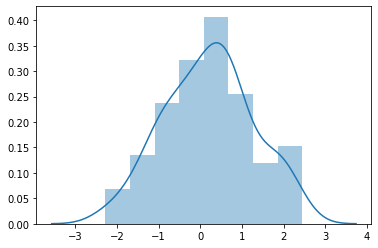

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.distplot(x)

In [6]:
goDict

{'GO:0046914': ['Zm00001d032873',
  'Zm00001d020257',
  'Zm00001d027454',
  'Zm00001d020425',
  'Zm00001d011272',
  'Zm00001d027720',
  'Zm00001d012910',
  'Zm00001d003353',
  'Zm00001d026513',
  'Zm00001d025654',
  'Zm00001d018495',
  'Zm00001d040253',
  'Zm00001d029248',
  'Zm00001d048513',
  'Zm00001d040252',
  'Zm00001d032291',
  'Zm00001d051472',
  'Zm00001d016577',
  'Zm00001d003866',
  'Zm00001d040637',
  'Zm00001d004019',
  'Zm00001d007130',
  'Zm00001d029752',
  'Zm00001d050277',
  'Zm00001d029499',
  'Zm00001d004138',
  'Zm00001d032517',
  'Zm00001d012221',
  'Zm00001d012033',
  'Zm00001d003365',
  'Zm00001d053438',
  'Zm00001d043868',
  'Zm00001d003358',
  'Zm00001d018075',
  'Zm00001d016691',
  'Zm00001d013473',
  'Zm00001d026298',
  'Zm00001d045649',
  'Zm00001d021059',
  'Zm00001d003357',
  'Zm00001d018491',
  'Zm00001d042344',
  'Zm00001d027708',
  'Zm00001d027405',
  'Zm00001d040040',
  'Zm00001d012484',
  'Zm00001d051611',
  'Zm00001d040839',
  'Zm00001d038815',
  'Zm0

96000

## Gene expression Var comparison

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats._knockoff import RegressionFDR

from scipy import stats
from scipy.stats import percentileofscore as percentile

In [51]:
dfvar = pd.read_csv('GE_Var_Trop_VS_Temperate.csv',index_col = 0)
dfvar.head()

zNormTrop  zNormTemperate
GRMZM5G807592   1.298394        2.797231
GRMZM5G862955   0.756999        0.345795
GRMZM5G876913   2.339050        4.590681
GRMZM5G881135   2.135769        4.773313
GRMZM5G892769   0.740845        0.967963

In [53]:
tropPct = []
tempPct = []
for a in dfvar.index:
    zNormTropP = stats.percentileofscore(dfvar['zNormTrop'], dfvar.loc[a]['zNormTrop'])
    zNormTempP = stats.percentileofscore(dfvar['zNormTemperate'], dfvar.loc[a]['zNormTemperate'])
    tropPct.append(zNormTropP)
    tempPct.append(zNormTempP)

In [54]:
dfvar['TropPercentile'] = tropPct
dfvar['TempPercentile'] = tempPct
dfvar.head()

zNormTrop  zNormTemperate  TropPercentile  TempPercentile
GRMZM5G807592   1.298394        2.797231       88.366982       99.018656
GRMZM5G862955   0.756999        0.345795       77.541528       67.651418
GRMZM5G876913   2.339050        4.590681       97.720419       99.984666
GRMZM5G881135   2.135769        4.773313       96.606185       99.989778
GRMZM5G892769   0.740845        0.967963       77.163302       82.550473

In [14]:
abgo = open('ATH_GO_GOSLIM.txt','r')
cDict={'P':'Biological process','C':'Cellular component','F':'Molecular function'}
abgoDict = {}
abgoList=[]
for aline in abgo:
    if aline.startswith('!'):continue
    GO = aline.strip().split('\t')[5]
    Desc = aline.strip().split('\t')[4]
    Category = cDict[aline.strip().split('\t')[7]]
    if not GO in abgoDict:
        abgoDict[GO]={}
        abgoDict[GO]['Desc']= Desc
        abgoDict[GO]['Category'] = Category
    else:continue

goDict={}
dfgo = open('All_ass.txt','r')
for aline in dfgo:
    x = aline.strip().split('\t')
    geneID = x[0]
    goList = x[1].split(';')
    for ago in goList:
        if not ago in abgoDict:continue
        elif not ago in goDict: goDict[ago]=[geneID]
        else: goDict[ago].append(geneID)

In [15]:
pList = []
GOHbDict={}
for ago in goDict:
    geneList = goDict[ago]
    geneIn = [x for x in geneList if x in dfvar.index]
    if len(geneIn)< 25:continue
    elif len(geneIn)>500:continue
    else: 
        GOHbDict[ago]={}
        pTrop = dfvar.loc[geneIn]['TropPercentile'].values
        pTemp = dfvar.loc[geneIn]['TempPercentile'].values
        #p = stats.ttest_ind(pTrop, pTemp)[1]
        p = stats.wilcoxon(pTrop,pTemp)[1]
        pList.append(p)
        fc = np.log2(np.mean(pTemp)/np.mean(pTrop))
        GOHbDict[ago]['desc'] = abgoDict[ago]['Desc']
        GOHbDict[ago]['Category'] = abgoDict[ago]['Category']
        GOHbDict[ago]['pValue'] = p
        GOHbDict[ago]['log2FoldChange'] = fc
        GOHbDict[ago]['AssignedGeneNumber'] = len(geneIn)
dfout = pd.DataFrame.from_dict(GOHbDict,orient='index')
dfout['FDR'] = fdr[1]
dfout

NameError: name 'dfvar' is not defined

In [77]:
dfout.loc[dfout.FDR<=0.05]

desc  \
GO:0010090                          trichome morphogenesis   
GO:0008017                             microtubule binding   
GO:0009524                                    phragmoplast   
GO:0001510                                 RNA methylation   
GO:0032040                        small-subunit processome   
GO:0009220  pyrimidine ribonucleotide biosynthetic process   
GO:0009630                                    gravitropism   
GO:0016926                           protein desumoylation   

                      Category        pValue  log2FoldChange  \
GO:0010090  Biological process  3.603931e-05        0.127677   
GO:0008017  Molecular function  1.315125e-05        0.137056   
GO:0009524  Cellular component  7.411597e-06        0.151572   
GO:0001510  Biological process  3.300202e-05       -0.159953   
GO:0032040  Cellular component  1.139017e-05       -0.311987   
GO:0009220  Biological process  2.948717e-05       -0.147082   
GO:0009630  Biological process  2.562957e-08        0.176205   
GO:0016926  Biological process  2.307463e-05        0.157148   

            AssignedGeneNumber       FDR  
GO:0010090                 156  0.034772  
GO:0008017                 164  0.012884  
GO:0009524                 102  0.007296  
GO:0001510                 227  0.031921  
GO:0032040                  62  0.011179  
GO:0009220                 164  0.028599  
GO:0009630                 153  0.000025  
GO:0016926                 101  0.022472

In [79]:
dfout.to_csv('ExpVar_GO.csv')

In [83]:
np.log2(1.1)

0.13750352374993502

In [1]:
0.05/19565

2.5555839509327884e-06

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats._knockoff import RegressionFDR
import statsmodels
from scipy import stats
from scipy.stats import percentileofscore as percentile

In [48]:
dfHbComp = pd.read_csv('Hb_Trop_VS_Temperate.csv',index_col = 0)
dfHbComp = dfHbComp.loc[dfHbComp.HbTrop > 0]
dfHbComp['Diff'] = 100*(dfHbComp.HbTemp-dfHbComp.HbTrop)/dfHbComp.HbTrop 
dfHbComp.to_csv("TropTempHbDiff.csv")
dfHbComp.head()

HbTrop    HbTemp
GRMZM5G807592  0.244016  0.000000
GRMZM5G862955  0.420597  0.092737
GRMZM5G876913  0.637457  0.000000
GRMZM5G881135  0.528033  0.000000
GRMZM5G892769  0.572605  0.321947

In [61]:
fpop = open('HbPop.list','w')
fstudy = open('HbTempLow.list','w')
for agene in dfHbComp.index:
    fpop.write(agene + '\n')
for agene in dfHbComp.loc[dfHbComp.Diff <= -80].index:
    fstudy.write(agene + '\n')
fpop.close()
fstudy.close()

(0.0, 1.5)

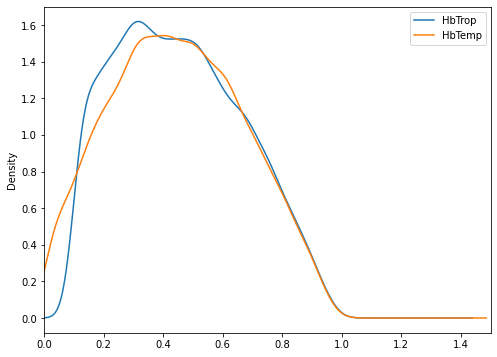

In [28]:
dfHbComp[['HbTrop', 'HbTemp']].plot(kind='density',figsize=(8,6))
plt.xlim(0,1.5)

In [29]:
expGeneList = dfHbComp.index
abgo = open('ATH_GO_GOSLIM.txt','r')
cDict={'P':'Biological process','C':'Cellular component','F':'Molecular function'}
abgoDict = {}
abgoList=[]
for aline in abgo:
    if aline.startswith('!'):continue
    GO = aline.strip().split('\t')[5]
    Desc = aline.strip().split('\t')[4]
    Category = cDict[aline.strip().split('\t')[7]]
    if not GO in abgoDict:
        abgoDict[GO]={}
        abgoDict[GO]['Desc']= Desc
        abgoDict[GO]['Category'] = Category
    else:continue

goDict={}
dfgo = open('All_ass.txt','r')
for aline in dfgo:
    x = aline.strip().split('\t')
    geneID = x[0]
    if not geneID in expGeneList: continue
    else: 
        goList = x[1].split(';')
        for ago in goList:
            if not ago in abgoDict:continue
            elif not ago in goDict: goDict[ago]=[geneID]
            else: goDict[ago].append(geneID)

In [30]:
pList = []
GOHbDict={}
for ago in goDict:
    geneIn = goDict[ago]
    #geneIn = [x for x in geneList if x in dfHbComp.index]
    if len(geneIn) < 20:continue
    elif len(geneIn)>100:continue
    else: 
        GOHbDict[ago]={}
        pTemp = dfHbComp.loc[geneIn]['HbTemp'].values
        pTrop = dfHbComp.loc[geneIn]['HbTrop'].values
        #p = stats.ttest_ind(pTrop, pTemp)[1]
        p = stats.wilcoxon(pTemp, pTrop)[1]
        pList.append(p)
        fc = np.log2(np.mean(pTemp)/np.mean(pTrop))
        GOHbDict[ago]['desc'] = abgoDict[ago]['Desc']
        GOHbDict[ago]['Category'] = abgoDict[ago]['Category']
        GOHbDict[ago]['pValue'] = p
        GOHbDict[ago]['log2FoldChange'] = fc
        GOHbDict[ago]['AssignedGeneNumber'] = len(geneIn)
fdr = statsmodels.stats.multitest.multipletests(pList, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)   
dfout = pd.DataFrame.from_dict(GOHbDict,orient='index')
dfout['FDR'] = fdr[1]
dfout.to_csv('ExpHb_Temp_vs_Trop_GO_Volcano.csv')
dfout

desc  \
GO:0050660                flavin adenine dinucleotide binding   
GO:0022900                           electron transport chain   
GO:0004190               aspartic-type endopeptidase activity   
GO:0000462  maturation of SSU-rRNA from tricistronic rRNA ...   
GO:0030170                        pyridoxal phosphate binding   
...                                                       ...   
GO:0002238              response to molecule of fungal origin   
GO:0043622                  cortical microtubule organization   
GO:0006352            DNA-templated transcription, initiation   
GO:0016790                      thiolester hydrolase activity   
GO:0006882                      cellular zinc ion homeostasis   

                      Category    pValue  log2FoldChange  AssignedGeneNumber  \
GO:0050660  Molecular function  0.110415       -0.096681                  78   
GO:0022900  Biological process  0.202552        0.088906                  67   
GO:0004190  Molecular function  0.345017        0.074310                  65   
GO:0000462  Biological process  0.001419       -0.549520                  37   
GO:0030170  Molecular function  0.043819        0.157486                  83   
...                        ...       ...             ...                 ...   
GO:0002238  Biological process  0.726184       -0.008507                  22   
GO:0043622  Biological process  0.245487       -0.200861                  20   
GO:0006352  Biological process  0.633827       -0.175814                  25   
GO:0016790  Molecular function  0.756166       -0.095228                  20   
GO:0006882  Biological process  0.026331        0.409356                  21   

                 FDR  
GO:0050660  1.000000  
GO:0022900  1.000000  
GO:0004190  1.000000  
GO:0000462  0.626753  
GO:0030170  1.000000  
...              ...  
GO:0002238  1.000000  
GO:0043622  1.000000  
GO:0006352  1.000000  
GO:0016790  1.000000  
GO:0006882  1.000000  

[710 rows x 6 columns]

In [35]:
dfout.loc[(dfout['FDR']<=0.05)]

desc  \
GO:0006346  DNA methylation-dependent heterochromatin asse...   
GO:0006606                        protein import into nucleus   
GO:0032040                           small-subunit processome   
GO:0003777                         microtubule motor activity   
GO:0005871                                    kinesin complex   

                      Category    pValue  log2FoldChange  AssignedGeneNumber  \
GO:0006346  Biological process  0.000003       -0.459059                  82   
GO:0006606  Biological process  0.000002       -0.410051                  88   
GO:0032040  Cellular component  0.000036       -0.630061                  42   
GO:0003777  Molecular function  0.000016       -0.416217                  53   
GO:0005871  Cellular component  0.000011       -0.534310                  44   

                 FDR  
GO:0006346  0.002215  
GO:0006606  0.001373  
GO:0032040  0.025020  
GO:0003777  0.011184  
GO:0005871  0.007647

In [34]:
dfsig = dfout.loc[(dfout['FDR']<=0.05) & (abs(dfout['log2FoldChange'])>=np.log2(1.1))]
dfsig = dfsig.reset_index().set_index('desc')
cList = []
for x in dfsig.index:
    if dfsig.loc[x]['log2FoldChange']>0 :cList.append('red')
    else: cList.append('orange')
dfsig['color'] = cList
dfsig

index  \
desc                                                             
DNA methylation-dependent heterochromatin assembly  GO:0006346   
protein import into nucleus                         GO:0006606   
small-subunit processome                            GO:0032040   
microtubule motor activity                          GO:0003777   
kinesin complex                                     GO:0005871   

                                                              Category  \
desc                                                                     
DNA methylation-dependent heterochromatin assembly  Biological process   
protein import into nucleus                         Biological process   
small-subunit processome                            Cellular component   
microtubule motor activity                          Molecular function   
kinesin complex                                     Cellular component   

                                                      pValue  log2FoldChange  \
desc                                                                           
DNA methylation-dependent heterochromatin assembly  0.000003       -0.459059   
protein import into nucleus                         0.000002       -0.410051   
small-subunit processome                            0.000036       -0.630061   
microtubule motor activity                          0.000016       -0.416217   
kinesin complex                                     0.000011       -0.534310   

                                                    AssignedGeneNumber  \
desc                                                                     
DNA methylation-dependent heterochromatin assembly                  82   
protein import into nucleus                                         88   
small-subunit processome                                            42   
microtubule motor activity                                          53   
kinesin complex                                                     44   

                                                         FDR   color  
desc                                                                  
DNA methylation-dependent heterochromatin assembly  0.002215  orange  
protein import into nucleus                         0.001373  orange  
small-subunit processome                            0.025020  orange  
microtubule motor activity                          0.011184  orange  
kinesin complex                                     0.007647  orange

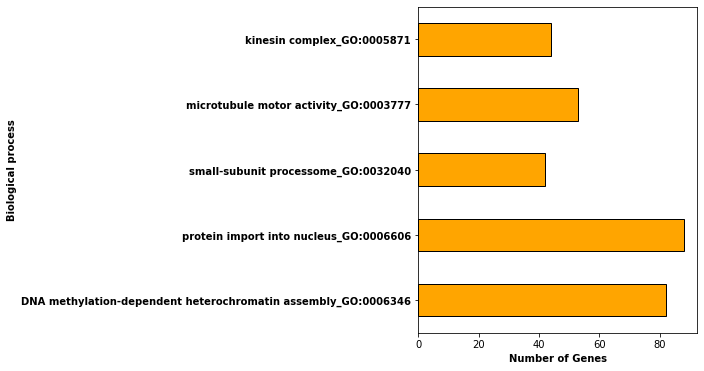

In [33]:
dfbar = dfsig.loc[(dfsig['AssignedGeneNumber']<=100)]# & (dfsig['Category'] == 'Biological process')]
dfbar.index = dfbar.index + '_' + dfbar['index']
dfbar['AssignedGeneNumber'].plot(kind='barh', figsize=(5,6), rot=0, color=dfbar.color, edgecolor='black')
plt.xlabel('Number of Genes',size=10, weight='bold')
plt.ylabel('Biological process', size=10, weight='bold')
plt.yticks(range(0,len(dfbar)), dfbar.index, size=10, weight='bold')
plt.savefig('geneNumberCountTempLowHbGO.svg')

In [42]:
dfeSum = pd.read_csv('eGWAS340_eQTL_Summary.csv')
dfeSum.head()

index          eQTL        R2          eTrait  eType         snpid  chr  \
0      0    4-33468930  0.098857  Zm00001d049558    cis    4-33468930    4   
1      0  10-111785228  0.544758  Zm00001d025286    cis  10-111785228   10   
2      1   2-173647447  0.072527  Zm00001d025286  trans   2-173647447    2   
3      2  10-134705962  0.092582  Zm00001d025286  trans  10-134705962   10   
4      0     2-5072839  0.295676  Zm00001d002051    cis     2-5072839    2   

         pos major minor       maf  
0   35022533     C     T  0.392647  
1  112649221     G     A  0.176471  
2  177835249     G     A  0.139706  
3  135930536     T     C  0.413235  
4    5016951     C     A  0.344118

In [43]:
dfbar

index            Category  \
mature ribosome assembly_GO:0042256         GO:0042256  Biological process   
manganese ion binding_GO:0030145            GO:0030145  Molecular function   
SNAP receptor activity_GO:0005484           GO:0005484  Molecular function   
regulation of apoptotic process_GO:0042981  GO:0042981  Biological process   
starch metabolic process_GO:0005982         GO:0005982  Biological process   
protein kinase binding_GO:0019901           GO:0019901  Molecular function   
Golgi transport complex_GO:0017119          GO:0017119  Cellular component   

                                                  pValue  log2FoldChange  \
mature ribosome assembly_GO:0042256         1.205260e-07       -0.378038   
manganese ion binding_GO:0030145            4.077831e-05       -0.429672   
SNAP receptor activity_GO:0005484           1.531549e-05       -0.284926   
regulation of apoptotic process_GO:0042981  2.007597e-05       -0.346330   
starch metabolic process_GO:0005982         5.347465e-05       -0.318113   
protein kinase binding_GO:0019901           1.138447e-05       -0.270926   
Golgi transport complex_GO:0017119          4.768372e-05       -0.678905   

                                            AssignedGeneNumber       FDR  \
mature ribosome assembly_GO:0042256                         79  0.000098   
manganese ion binding_GO:0030145                            45  0.032334   
SNAP receptor activity_GO:0005484                           58  0.012314   
regulation of apoptotic process_GO:0042981                  66  0.016071   
starch metabolic process_GO:0005982                         50  0.042084   
protein kinase binding_GO:0019901                           71  0.009179   
Golgi transport complex_GO:0017119                          20  0.037659   

                                             color  
mature ribosome assembly_GO:0042256         orange  
manganese ion binding_GO:0030145            orange  
SNAP receptor activity_GO:0005484           orange  
regulation of apoptotic process_GO:0042981  orange  
starch metabolic process_GO:0005982         orange  
protein kinase binding_GO:0019901           orange  
Golgi transport complex_GO:0017119          orange

In [44]:
fout = open('RegionalSigGO_GeneList.csv','w')
for x in dfbar.index:
    GO = x.split('_')[-1]
    geneList = goDict[GO]
    desc = '_'.join(x.split())
    for agene in geneList:
        if agene in dfeSum['eTrait'].values: e = 'with_eQTL'
        else: e = 'no_eQTL'
        fout.write(GO+ '\t' + desc +  '\t' + agene + '\t' + e +'\n')
fout.close()

In [45]:
dfReginalSigGO = pd.read_csv('RegionalSigGO_GeneList.csv',sep = '\t', header = None)
dfReginalSigGO.columns = ['GO','Desc', 'geneID','eTraitOrNot']
dfReginalSigGO.set_index('GO',inplace=True)
dfReginalSigGO

Desc          geneID eTraitOrNot
GO                                                                         
GO:0042256  mature_ribosome_assembly_GO:0042256  Zm00001d022180     no_eQTL
GO:0042256  mature_ribosome_assembly_GO:0042256  Zm00001d048256   with_eQTL
GO:0042256  mature_ribosome_assembly_GO:0042256  Zm00001d010566     no_eQTL
GO:0042256  mature_ribosome_assembly_GO:0042256  Zm00001d013252     no_eQTL
GO:0042256  mature_ribosome_assembly_GO:0042256  Zm00001d037489   with_eQTL
...                                         ...             ...         ...
GO:0017119   Golgi_transport_complex_GO:0017119  Zm00001d012851     no_eQTL
GO:0017119   Golgi_transport_complex_GO:0017119  Zm00001d046945     no_eQTL
GO:0017119   Golgi_transport_complex_GO:0017119  Zm00001d030527   with_eQTL
GO:0017119   Golgi_transport_complex_GO:0017119  Zm00001d046973     no_eQTL
GO:0017119   Golgi_transport_complex_GO:0017119  Zm00001d048320   with_eQTL

[389 rows x 3 columns]

In [46]:
from collections import Counter
eGOCount = {}
for x in dfReginalSigGO.index:
    eTraitList = dfReginalSigGO.loc[x]['eTraitOrNot']
    eGOCount[x] = Counter(eTraitList)

In [47]:
from collections import Counter
eGOCount = {}
for x in dfReginalSigGO.index:
    eTraitList = dfReginalSigGO.loc[x]['eTraitOrNot']
    eGOCount[x] = Counter(eTraitList)
dfstackBar = pd.DataFrame.from_dict(eGOCount).transpose()
dfstackBar.index = dfbar.index
dfstackBar['color'] = dfbar.color
dfstackBar.sort_values(by='color',inplace=True)
dfstackBar

no_eQTL  with_eQTL   color
mature ribosome assembly_GO:0042256              39         40  orange
manganese ion binding_GO:0030145                 18         27  orange
SNAP receptor activity_GO:0005484                 9         49  orange
regulation of apoptotic process_GO:0042981       25         41  orange
starch metabolic process_GO:0005982              21         29  orange
protein kinase binding_GO:0019901                27         44  orange
Golgi transport complex_GO:0017119                9         11  orange

Text(0.5, 0, 'Number of Genes')

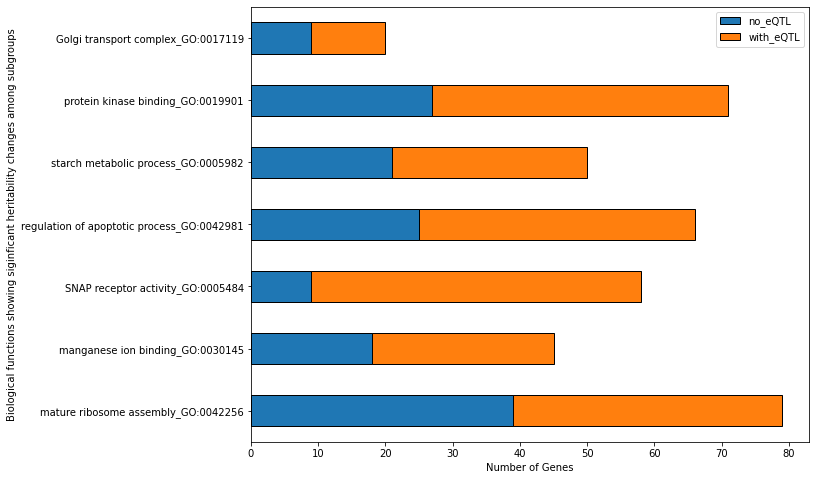

In [48]:
dfstackBar.plot(kind='barh',stacked='True', figsize= (10,8), rot=0, edgecolor='black')
plt.ylabel('Biological functions showing siginficant heritability changes among subgroups')
plt.xlabel('Number of Genes')

In [115]:
eTraitList = dfTmLwHbGO.loc[dfTmLwHbGO['eTraitOrNot'] == 'with_eQTL']['geneID']
dfeSum.set_index('eTrait').loc[eTraitList]

index         eQTL        R2  eType        snpid  chr  \
eTrait                                                                  
Zm00001d021636      0   6-37584739  0.295646  trans   6-37584739    6   
Zm00001d015314      0   5-82124993  0.123778    cis   5-82124993    5   
Zm00001d022313      0  7-169443751  0.422349    cis  7-169443751    7   
Zm00001d027479      0    1-6168188  0.281848    cis    1-6168188    1   
Zm00001d013976      0   5-26334478  0.112979    cis   5-26334478    5   
...               ...          ...       ...    ...          ...  ...   
Zm00001d045272      0   9-16686919  0.025041  trans   9-16686919    9   
Zm00001d045272      1   7-99107376  0.047737  trans   7-99107376    7   
Zm00001d045272      2   9-17953350  0.278772    cis   9-17953350    9   
Zm00001d045272      3   9-15329924  0.181219  trans   9-15329924    9   
Zm00001d029104      0   1-57453516  0.221166    cis   1-57453516    1   

                      pos major minor       maf  
eTrait                                           
Zm00001d021636   39366942     G     A  0.054412  
Zm00001d015314   84268158     G     A  0.183824  
Zm00001d022313  174972080     A     G  0.238235  
Zm00001d027479    6250721     G     T  0.204412  
Zm00001d013976   26947182     G     A  0.241176  
...                   ...   ...   ...       ...  
Zm00001d045272   16430437     G     T  0.216176  
Zm00001d045272  102188288     C     T  0.150000  
Zm00001d045272   17799156     A     T  0.452941  
Zm00001d045272   15054343     C     A  0.058824  
Zm00001d029104   58170119     T     G  0.080882  

[403 rows x 10 columns]

In [3]:
dfqnbFittedRct = pd.read_csv('eGWAS340_qnbFitted_Count.csv', index_col = 0)
dfqnbFittedRct.columns = [x.split('.')[0] for x in list(dfqnbFittedRct)]
dfqnbFittedRct.head()

1             1            10            10  \
GRMZM5G807592  3.005427e+07  2.774649e+07  4.121356e+07  3.130019e+07   
GRMZM5G862955  3.031509e+07  2.798728e+07  4.193199e+07  3.184581e+07   
GRMZM5G876913  3.007347e+07  2.776422e+07  4.126625e+07  3.134020e+07   
GRMZM5G881135  3.010315e+07  2.779161e+07  4.134772e+07  3.140208e+07   
GRMZM5G892769  3.015866e+07  2.784287e+07  4.150037e+07  3.151801e+07   

                        100           100           101           101  \
GRMZM5G807592  3.145429e+07  4.344751e+07  3.558592e+07  3.029863e+07   
GRMZM5G862955  3.228033e+07  4.458850e+07  3.683739e+07  3.136416e+07   
GRMZM5G876913  3.151462e+07  4.353084e+07  3.567696e+07  3.037614e+07   
GRMZM5G881135  3.160801e+07  4.365983e+07  3.581798e+07  3.049621e+07   
GRMZM5G892769  3.178320e+07  4.390183e+07  3.608293e+07  3.072180e+07   

                        102           102  ...      N84-2        N88  \
GRMZM5G807592  2.606107e+07  3.704366e+07  ...   4.923701   4.304272   
GRMZM5G862955  2.721169e+07  3.867918e+07  ...  89.009320  78.486734   
GRMZM5G876913  2.614444e+07  3.716216e+07  ...   6.098500   5.334682   
GRMZM5G881135  2.627368e+07  3.734587e+07  ...   8.486159   7.430619   
GRMZM5G892769  2.651684e+07  3.769151e+07  ...  15.731596  13.800245   

                     N88         N9         N9         N94        N94  \
GRMZM5G807592   3.531095   5.137710   4.495464    5.619227   4.318938   
GRMZM5G862955  64.388151  94.497159  82.684428  104.250573  80.126989   
GRMZM5G876913   4.376413   6.371707   5.575204    6.973330   5.359701   
GRMZM5G881135   6.095856   8.883837   7.773302    9.732252   7.480209   
GRMZM5G892769  11.321305  16.529608  14.463304   18.141596  13.943631   

                     N96        N96      N99-2  
GRMZM5G807592   4.826671   4.212859   2.976242  
GRMZM5G862955  90.323808  78.837247  56.179191  
GRMZM5G876913   5.993614   5.231400   3.698169  
GRMZM5G881135   8.373175   7.308351   5.171500  
GRMZM5G892769  15.636967  13.648400   9.675625  

[5 rows x 572 columns]

In [7]:
import pandas as pd, numpy as np
from collections import Counter
import scipy
from scipy import stats
eDict={}
tDict={}

dfexpRenamedMerged = pd.DataFrame(index = dfqnbFittedRct.index)
repCount = Counter(list(dfqnbFittedRct))
singleList = [x for x in repCount if repCount[x] ==1]
sampleList = list(set(list(dfqnbFittedRct)))
sampleList.sort()
for x in sampleList:
    if x in singleList: dfexpRenamedMerged[x] = dfqnbFittedRct[x]
    else: dfexpRenamedMerged[x] = dfqnbFittedRct[x].mean(axis=1)
        
for agene in dfexpRenamedMerged.index:
    geList = dfexpRenamedMerged.loc[agene].values
    geList = np.log(geList) #[float(x) + 0.00001 for x in geList]#adding a small random number beneath the minimum detection threshold in avoid zero
    #ge_boxcox=scipy.stats.boxcox(geList)[0]
    tDict[agene]=geList
    
dfexpRenamedMergedTransformed = pd.DataFrame.from_dict(tDict,orient='index',columns=list(dfexpRenamedMerged))

dfexpRenamedMergedTransformed.to_csv('eGWAS340_qnbFitted_RepMerged_LogTransformed_Cts.csv',sep='\t')
#dfexpRenamedMerged.to_csv('eGWAS340_RepMerged_Untransformed_FPKM.csv')
dfexpRenamedMergedTransformed.head()

1         10        100        101        102  \
GRMZM5G807592  17.179365  17.406140  17.438541  17.310267  17.267159   
GRMZM5G862955  17.188006  17.423421  17.464464  17.344831  17.310363   
GRMZM5G876913  17.180004  17.407417  17.440458  17.312822  17.270353   
GRMZM5G881135  17.180990  17.409390  17.443416  17.316767  17.275284   
GRMZM5G892769  17.182833  17.413075  17.448944  17.324137  17.284497   

                     103        104      105-1      105-2        106  ...  \
GRMZM5G807592  17.071963  17.011347  16.991151  16.962936  16.873555  ...   
GRMZM5G862955  17.123808  17.071833  17.060278  17.040703  16.959963  ...   
GRMZM5G876913  17.075796  17.015819  16.996261  16.968684  16.879943  ...   
GRMZM5G881135  17.081713  17.022722  17.004151  16.977561  16.889805  ...   
GRMZM5G892769  17.092768  17.035620  17.018891  16.994143  16.908230  ...   

                     N8       N81       N82     N84-1     N84-2       N88  \
GRMZM5G807592  1.691790  1.912385  1.773838  1.543135  1.594060  1.365501   
GRMZM5G862955  4.551907  4.781143  4.651237  4.429175  4.488741  4.268822   
GRMZM5G876913  1.903218  2.124451  1.986543  1.756479  1.808043  1.580122   
GRMZM5G881135  2.229666  2.451886  2.314964  2.085886  2.138437  1.911502   
GRMZM5G892769  2.839531  3.063593  2.928513  2.701278  2.755671  2.530579   

                     N9       N94       N96     N99-2  
GRMZM5G807592  1.572066  1.603235  1.508460  1.090662  
GRMZM5G862955  4.484028  4.523838  4.437704  4.028546  
GRMZM5G876913  1.787326  1.819134  1.724998  1.307838  
GRMZM5G881135  2.119692  2.152486  2.059336  1.643163  
GRMZM5G892769  2.740611  2.775249  2.683941  2.269610  

[5 rows x 340 columns]